In [1]:
import pandas as pd
import scipy as sp
import numpy as np

import emcee
from multiprocessing import Pool

import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from matplotlib import font_manager
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap
from cycler import cycler
import corner
from typing import Any, Dict, List, Optional, Tuple, Union

import lymph

In [2]:
filename = "../data/extended_system.hdf5"

extended_systm = lymph.utils.system_from_hdf(
    filename=filename,
    name="extended/model")

samples_HMM = emcee.backends.HDFBackend(filename=filename, name="extended/samples").get_chain(flat=True, discard=5000)

spread_probs = np.array([sample[:-1] for sample in samples_HMM])
late_p_samples = np.array([sample[-1] for sample in samples_HMM])

extended_systm.spread_probs = np.mean(spread_probs, axis=0)
mean_late_p = np.mean(np.array(late_p_samples), axis=0)


Loading patients of late T-stage


100%|██████████| 14336/14336 [00:12<00:00, 1155.54it/s]


Loading patients of early T-stage


100%|██████████| 20864/20864 [00:17<00:00, 1187.82it/s]


## Plot Settings



In [22]:
plt.style.use("../styles/lymph.mplstyle")

def set_size(width="single", unit="cm", ratio="golden"):
    if width == "single":
        width = 10
    elif width == "full":
        width = 32
    else:
        try:
            width = width
        except:
            width = 10

    if unit == "cm":
        width = width / 2.54

    if ratio == "golden":
        ratio = 1.618
    else:
        ratio = ratio

    try:
        height = width / ratio
    except:
        height = width / 1.618

    return (width, height)

labels = [r"$\tilde{b}_1$", r"$\tilde{b}_2$", r"$\tilde{b}_3$",
          r"$\tilde{b}_4$", r"$\tilde{b}_5$", r"$\tilde{b}_7$",
          r"$\tilde{t}_{21}$", r"$\tilde{t}_{23}$", r"$\tilde{t}_{25}$", r"$\tilde{t}_{27}$", r"$\tilde{t}_{36}$"]


fig = plt.figure(figsize=set_size(width="full", ratio=1))


# USZ colors
usz_blue = '#005ea8'
usz_green = '#00afa5'
usz_red = '#ae0060'
usz_orange = '#f17900'
usz_gray = '#c5d5db'

# colormaps
white_to_blue  = LinearSegmentedColormap.from_list("white_to_blue", 
                                                   ["#ffffff", usz_blue], 
                                                   N=256)
white_to_green = LinearSegmentedColormap.from_list("white_to_green", 
                                                   ["#ffffff", usz_green], 
                                                   N=256)
green_to_red   = LinearSegmentedColormap.from_list("green_to_red", 
                                                   [usz_green, usz_red], 
                                                   N=256)

h = usz_gray.lstrip('#')
gray_rgba = tuple(int(h[i:i+2], 16) / 255. for i in (0, 2, 4)) + (1.0,)
tmp = LinearSegmentedColormap.from_list("tmp", [usz_green, usz_red], N=128)
tmp = tmp(np.linspace(0., 1., 128))
tmp = np.vstack([np.array([gray_rgba]*128), tmp])
halfGray_halfGreenToRed = ListedColormap(tmp)

<Figure size 1889.76x1889.76 with 0 Axes>

## Corner Plot


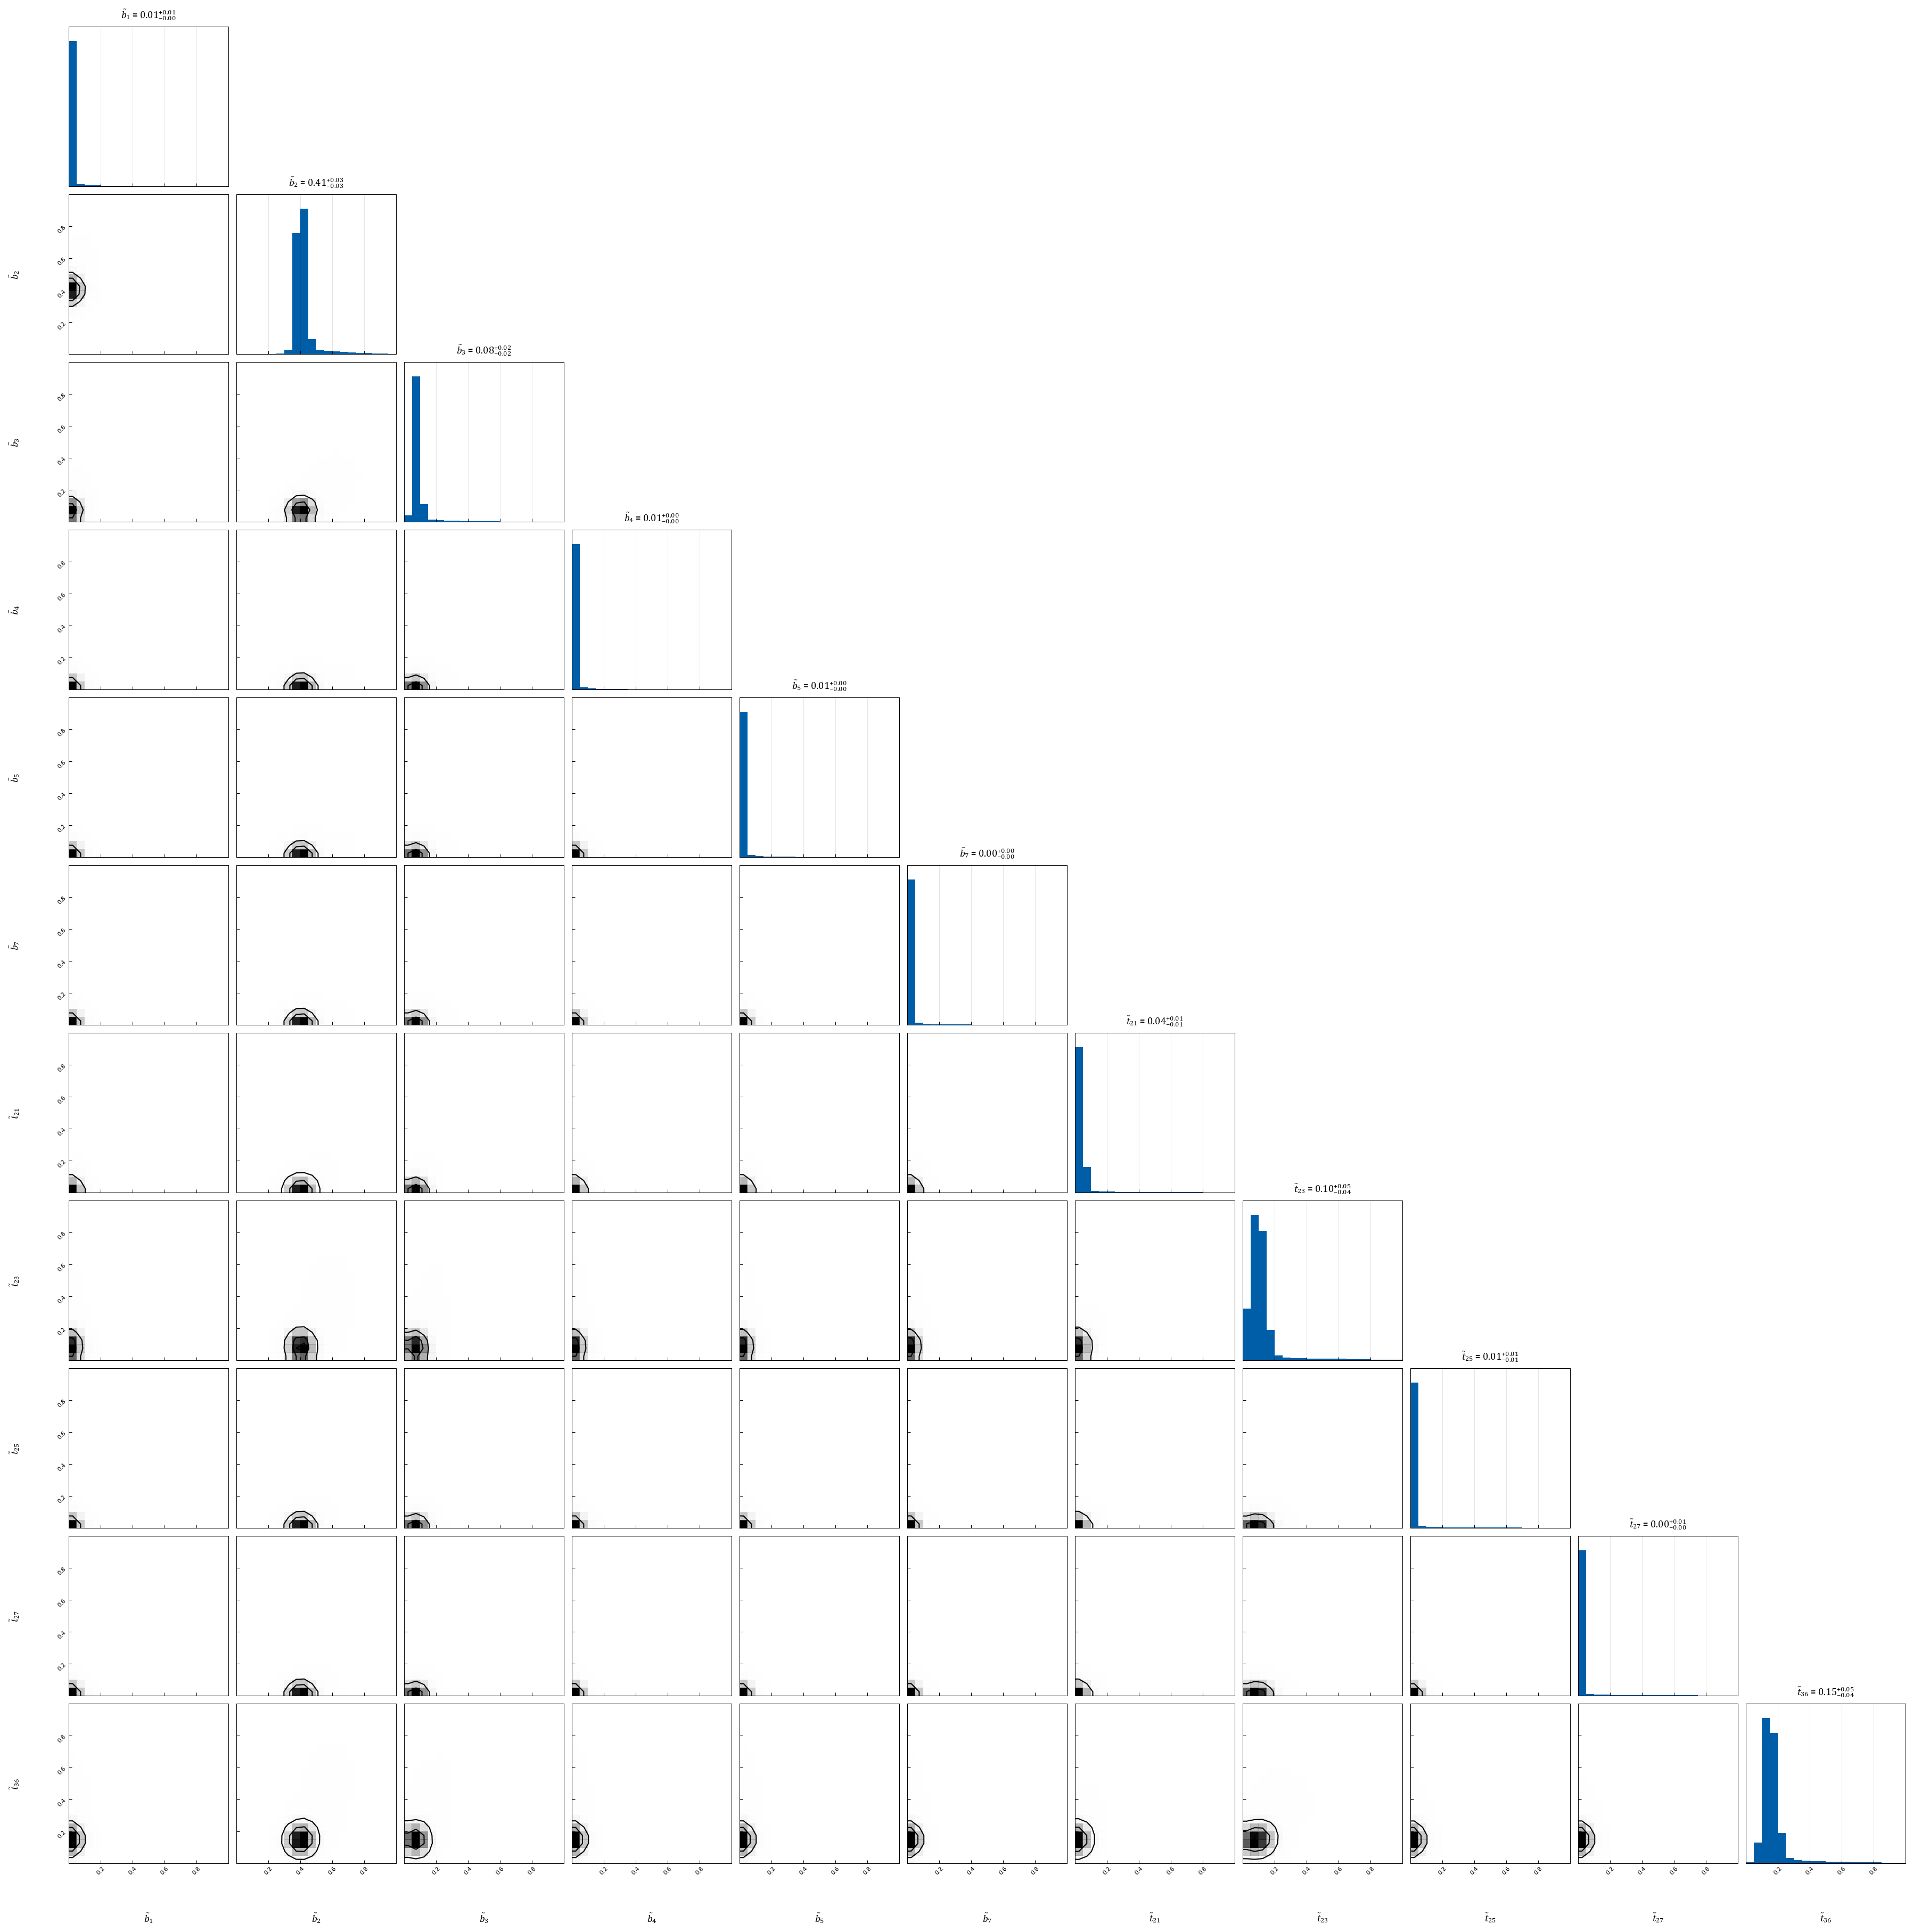

In [24]:
corner.corner(spread, labels=labels, smooth=True, 
              hist_kwargs={'histtype': 'stepfilled', 'color': usz_blue},
              **{'plot_datapoints': False, 'no_fill_contours': True,
                 "density_cmap": white_to_blue.reversed(),
                 "contour_kwargs": {"colors": "k"},
                 "levels": np.array([0.2, 0.5, 0.8])},
              show_titles=True, title_kwargs={"fontsize": "medium"})

axes = fig.get_axes()
for ax in axes:
    ax.grid(False)


plt.savefig("../plots/corner_HMM.png", dpi=300, bbox_inches="tight")
plt.savefig("../plots/corner_HMM.svg", bbox_inches="tight")

## Transition Matrix


In [26]:

# modify the transition matrix for nicer coloring
# mod_A = -1 * np.ones_like(extended_systm.A)
# for key, nums in extended_systm.mask.items():
#     for i in nums:
#         mod_A[key, i] = extended_systm.A[key, i]

mod_A = extended_systm.transition_matrix

# Divide the Matrix into three submatrices
x_values = [extended_systm.state_list[:32],extended_systm.state_list[32:], extended_systm.state_list[32:]]
y_values = [extended_systm.state_list[:32],extended_systm.state_list[:32], extended_systm.state_list[32:]]
partA = [mod_A[:32,:32], mod_A[:32,32:], mod_A[32:,32:]]
name = ["1", "2","3"]

#Create the plot for each submatrix
for k , val in enumerate(x_values):
    fig, ax = plt.subplots(figsize=set_size(ratio=1., width="full"),
                       constrained_layout=True)

    h = ax.imshow(partA[k], cmap=halfGray_halfGreenToRed, vmin=-1., vmax=1.)
    ax.set_xticks(range(len(x_values[k])))
    ax.set_xticklabels(x_values[k], rotation=-90, fontsize=20)
    ax.set_yticks(range(len(y_values[k])))
    ax.set_yticklabels(y_values[k], fontsize=20)
    ax.tick_params(direction="out")
    ax.grid(False)

    # label the non-zero entries with their probability in %
    for i in range(len(x_values[k])):
        for j in range(len(y_values[k])):
            if mod_A[i, j] >= 0.:
                ax.text(j, i, f"{partA[k][i,j]*100:.1f}", ha="center", va="center",
                        color="white", fontsize=14)

    plt.savefig(f"../plots/transition_matrix{name[k]}.png", dpi=300, bbox_inches="tight")
    plt.savefig(f"../plots/transition_matrix{name[k]}.svg", bbox_inches="tight")
    plt.clf()

C:\Users\Luca\anaconda3\envs\lymph2\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


<Figure size 1889.76x1889.76 with 0 Axes>

<Figure size 1889.76x1889.76 with 0 Axes>

<Figure size 1889.76x1889.76 with 0 Axes>